In [33]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-detection/fake_news_dataset.csv


## **Introduction**

Distinguishing real news from fake has become a critical challenge for society, media, and technology in this era where misinformation proliferates across digital platforms. This project will attempt to tackle fake news detection using machine learning techniques and a dataset of 4,000 news articles, featuring 24 metadata columns—ranging from linguistic features like sentiment_score and word_count to credibility indicators like source_reputation and fact_check_rating. The dataset blends reliable sources (e.g., New York Times) with misleading ones (e.g., The Onion), offering a real-world lens into misinformation dynamics. The stakes are high: unchecked fake news erodes trust, sways public opinion, and undermines democratic processes. My goal is to build a robust machine learning model to classify news authenticity, leveraging metadata to uncover patterns that traditional content analysis might miss.

Sentiment analysis plays a pivotal role here, as sentiment_score (-1 to 1) captures emotional tone—a potential marker of sensationalism or bias often linked to fake news. By integrating this with statistical (e.g., word_count), social (e.g., num_shares), and credibility features (e.g., trust_score), I aim to create a multidimensional approach that outperforms simpler text-based methods. This project, crafted for my portfolio, demonstrates my expertise in NLP, feature engineering, and supervised learning—skills vital for roles in data science and misinformation mitigation.

**Problem Statement**

Develop an accurate classifier to distinguish “Real” from “Fake” news articles using metadata, addressing the challenge of misinformation in a diverse, real-world dataset.

**Objective**

The project will design and evaluate a machine learning pipeline that achieves high precision and recall in detecting fake news.

**Steps and Expected Outcomes**

1. **Exploratory Data Analysis (EDA):** Investigate distributions, correlations, and class balance (Real vs. Fake) to identify key predictors—e.g., does high clickbait_score correlate with “Fake”? Expect to uncover metadata patterns distinguishing authenticity.
2. **Preprocessing:** Clean and encode data (e.g., one-hot category, parse date_published), handle text features (title, text), and scale numerical columns. Aim for a robust, model-ready dataset.
3. **Feature Engineering:** Extract advanced features—e.g., text complexity from text, sentiment polarity trends—enhancing predictive power beyond raw metadata.
4. **Model Development:** Train and tune classifiers (e.g., Logistic Regression, Random Forest, XGBoost) on metadata, incorporating sentiment and credibility signals. Target >85% accuracy, prioritizing recall for fake news detection.
5. **Evaluation and Interpretation:** Assess performance with precision, recall, F1-score, and feature importance—explaining why sentiment or source_reputation matters. Deliver a clear, actionable model.
6. **Conclusion:** Summarize findings.

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

## **Data Loading and Cleaning**

In [35]:
# load the data and view first 5 entries
df = pd.read_csv('/kaggle/input/fake-news-detection/fake_news_dataset.csv')
df.head()

,id,title,author,text,state,date_published,source,category,sentiment_score,word_count,...,num_shares,num_comments,political_bias,fact_check_rating,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score,label
0,1,Breaking News 1,Jane Smith,This is the content of article 1. It contains ...,Tennessee,30-11-2021,The Onion,Entertainment,-0.22,1302,...,47305,450,Center,FALSE,1,76,6,0.84,53.35,Fake
1,2,Breaking News 2,Emily Davis,This is the content of article 2. It contains ...,Wisconsin,02-09-2021,The Guardian,Technology,0.92,322,...,39804,530,Left,Mixed,1,1,5,0.85,28.28,Fake
2,3,Breaking News 3,John Doe,This is the content of article 3. It contains ...,Missouri,13-04-2021,New York Times,Sports,0.25,228,...,45860,763,Center,Mixed,0,57,1,0.72,0.38,Fake
3,4,Breaking News 4,Alex Johnson,This is the content of article 4. It contains ...,North Carolina,08-03-2020,CNN,Sports,0.94,155,...,34222,945,Center,TRUE,1,18,10,0.92,32.20,Fake
4,5,Breaking News 5,Emily Davis,This is the content of article 5. It contains ...,California,23-03-2022,Daily Mail,Technology,-0.01,962,...,35934,433,Right,Mixed,0,95,6,0.66,77.70,Real


In [36]:
# check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4000 non-null   int64  
 1   title              4000 non-null   object 
 2   author             4000 non-null   object 
 3   text               4000 non-null   object 
 4   state              4000 non-null   object 
 5   date_published     4000 non-null   object 
 6   source             4000 non-null   object 
 7   category           4000 non-null   object 
 8   sentiment_score    4000 non-null   float64
 9   word_count         4000 non-null   int64  
 10  char_count         4000 non-null   int64  
 11  has_images         4000 non-null   int64  
 12  has_videos         4000 non-null   int64  
 13  readability_score  4000 non-null   float64
 14  num_shares         4000 non-null   int64  
 15  num_comments       4000 non-null   int64  
 16  political_bias     4000 

In [37]:
# check null values
df.isnull().sum()

id                   0
title                0
author               0
text                 0
state                0
date_published       0
source               0
category             0
sentiment_score      0
word_count           0
char_count           0
has_images           0
has_videos           0
readability_score    0
num_shares           0
num_comments         0
political_bias       0
fact_check_rating    0
is_satirical         0
trust_score          0
source_reputation    0
clickbait_score      0
plagiarism_score     0
label                0
dtype: int64

In [38]:
# check for duplicated entries
df.duplicated().sum()

0

In [39]:
# view summary statistics for numerical variables
df.describe()

,id,sentiment_score,word_count,char_count,has_images,has_videos,readability_score,num_shares,num_comments,is_satirical,trust_score,source_reputation,clickbait_score,plagiarism_score
count,4000.000000,4000.000000,4000.000000,4000.0000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000
mean,2000.500000,-0.000645,795.655750,4277.0680,0.49650,0.484500,54.764595,25144.596750,489.870250,0.497000,49.960750,5.54925,0.494447,50.598110
std,1154.844867,0.574768,406.373871,2186.2073,0.50005,0.499822,14.404027,14387.537467,287.435733,0.500054,29.467911,2.87422,0.289138,28.932298
min,1.000000,-1.000000,100.000000,500.0000,0.00000,0.000000,30.020000,39.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.040000
25%,1000.750000,-0.490000,445.750000,2358.7500,0.00000,0.000000,42.480000,12781.750000,238.000000,0.000000,24.000000,3.00000,0.240000,25.915000
50%,2000.500000,-0.010000,793.000000,4287.0000,0.00000,0.000000,54.235000,25308.500000,483.000000,0.000000,50.000000,6.00000,0.490000,51.480000
75%,3000.250000,0.510000,1150.000000,6206.5000,1.00000,1.000000,67.215000,37453.500000,741.000000,1.000000,76.000000,8.00000,0.740000,75.580000
max,4000.000000,1.000000,1500.000000,7996.0000,1.00000,1.000000,79.980000,50000.000000,1000.000000,1.000000,100.000000,10.00000,1.000000,99.950000


## **Exploratory Data Analysis**

In this section, we will analyze distributions, class balance, and relationships (e.g., sentiment_score vs. label, source_reputation vs. is_satirical) to identify predictive signals.

In [40]:
# Class balance
print("Label Distribution:\n", df['label'].value_counts(normalize=True))

Label Distribution:
 label
Fake    0.5065
Real    0.4935
Name: proportion, dtype: float64


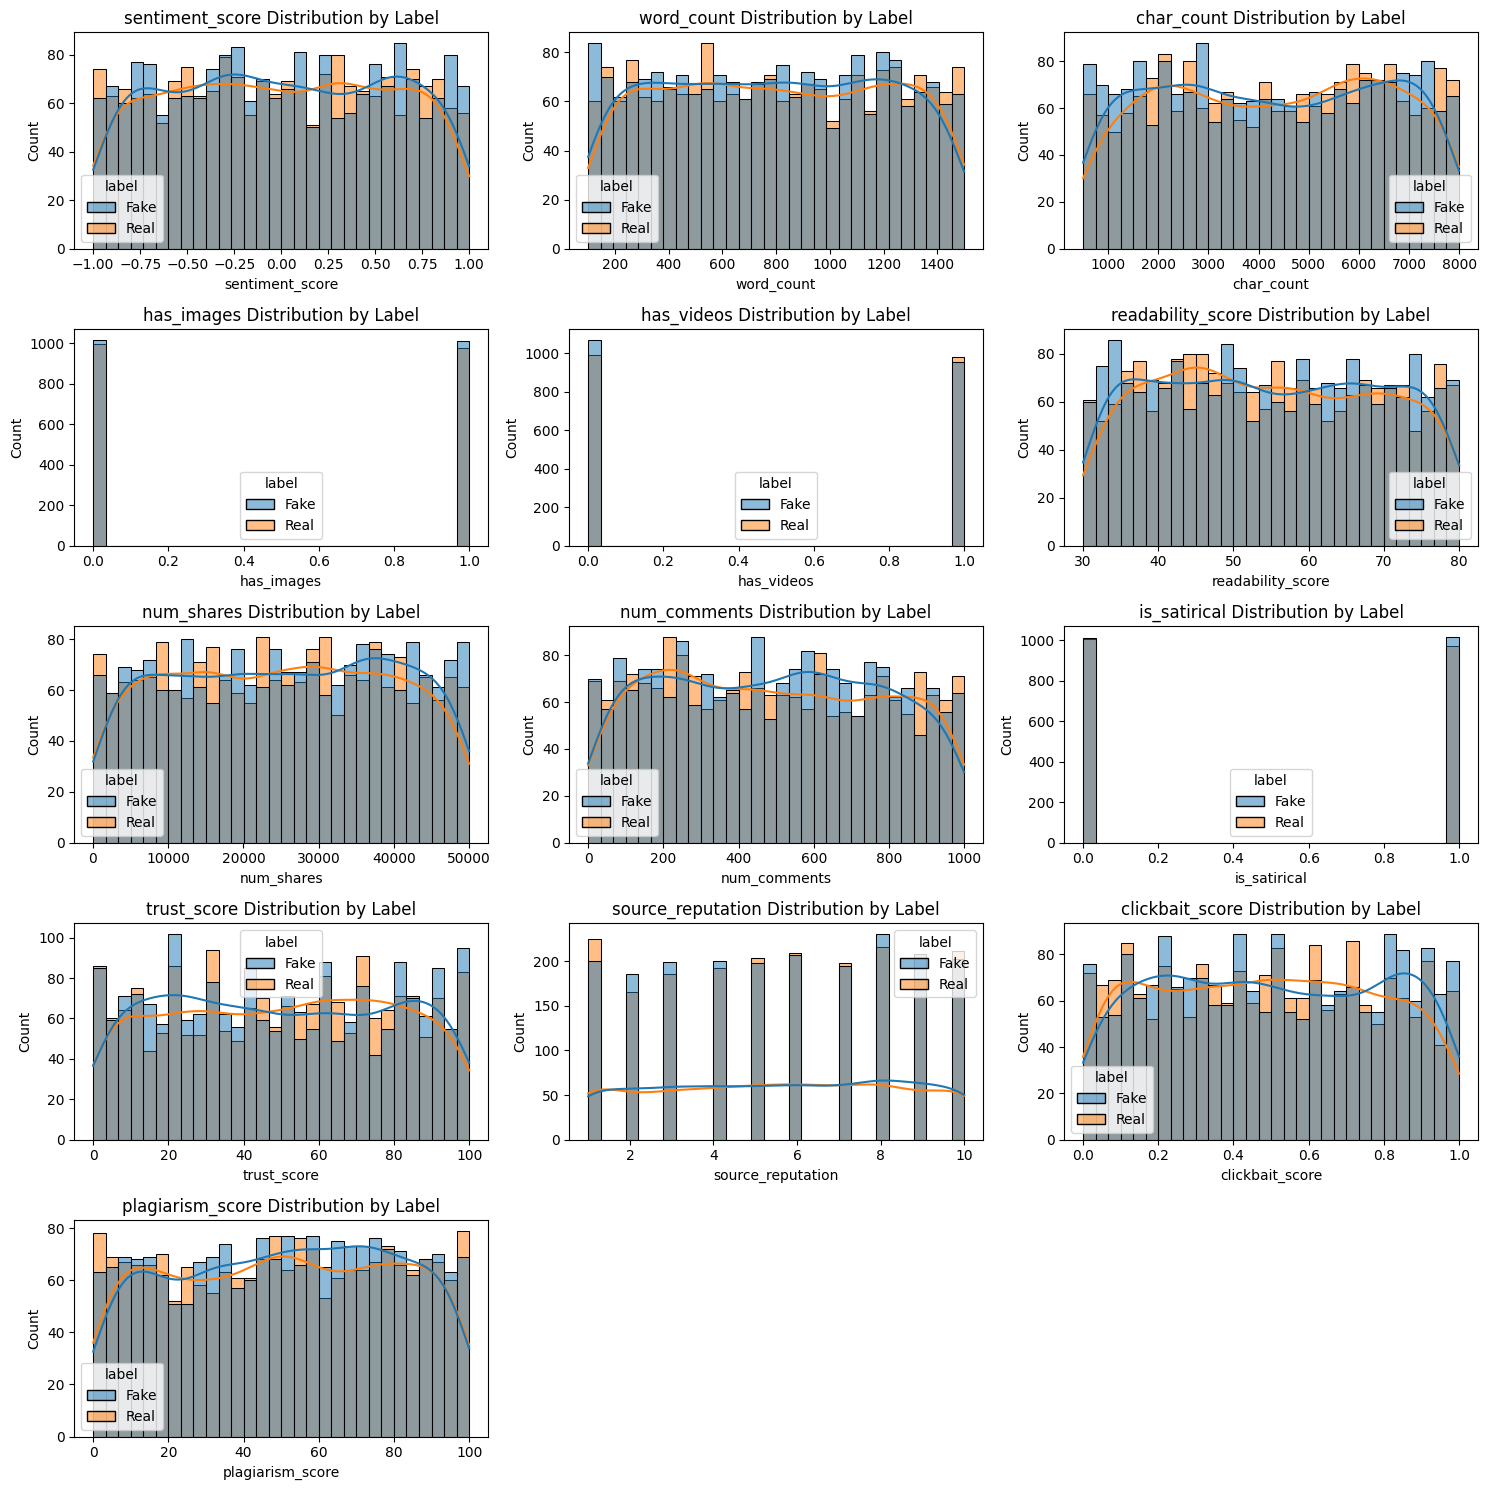

In [41]:
# Numerical features distribution
numerical_cols = ['sentiment_score', 'word_count', 'char_count', 'has_images', 'has_videos', 
                  'readability_score', 'num_shares', 'num_comments', 'is_satirical', 
                  'trust_score', 'source_reputation', 'clickbait_score', 'plagiarism_score']
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 3, i)
    sns.histplot(data=df, x=col, hue='label', bins=30, kde=True if col not in ['has_images', 'has_videos', 'is_satirical'] else False)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

In [42]:
# Categorical features 
categorical_cols = ['category', 'political_bias', 'fact_check_rating', 'state', 'source']
for col in categorical_cols:
    print(f"\n{col} vs. Label:\n", pd.crosstab(df[col], df['label'], normalize='index').head(10)) # Top 10 for brevity


category vs. Label:
 label              Fake      Real
category                         
Business       0.504144  0.495856
Entertainment  0.540284  0.459716
Health         0.494964  0.505036
Politics       0.496241  0.503759
Sports         0.512422  0.487578
Technology     0.492958  0.507042

political_bias vs. Label:
 label               Fake      Real
political_bias                    
Center          0.530566  0.469434
Left            0.498895  0.501105
Right           0.490137  0.509863

fact_check_rating vs. Label:
 label                  Fake      Real
fact_check_rating                    
FALSE              0.520089  0.479911
Mixed              0.495627  0.504373
TRUE               0.503894  0.496106

state vs. Label:
 label              Fake      Real
state                            
Arizona        0.456989  0.543011
California     0.511111  0.488889
Florida        0.459091  0.540909
Georgia        0.485549  0.514451
Illinois       0.517588  0.482412
Indiana        0.451456  

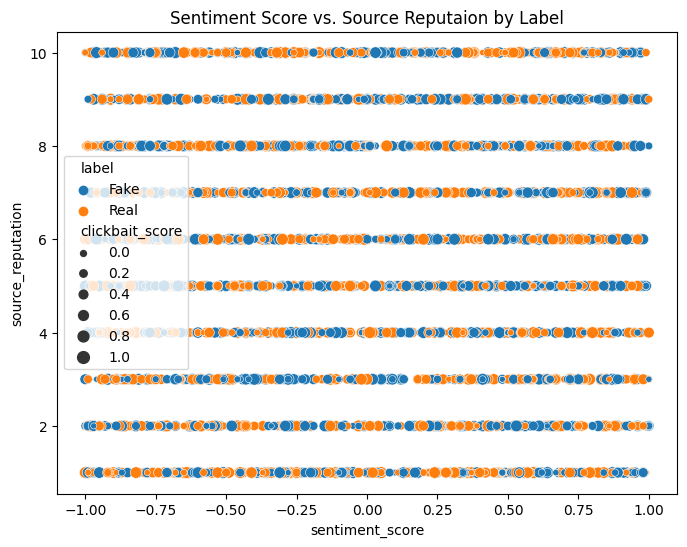

In [43]:
# Sentiment v. Credibility
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='sentiment_score', y='source_reputation', hue='label', size='clickbait_score')
plt.title('Sentiment Score vs. Source Reputaion by Label')
plt.show()

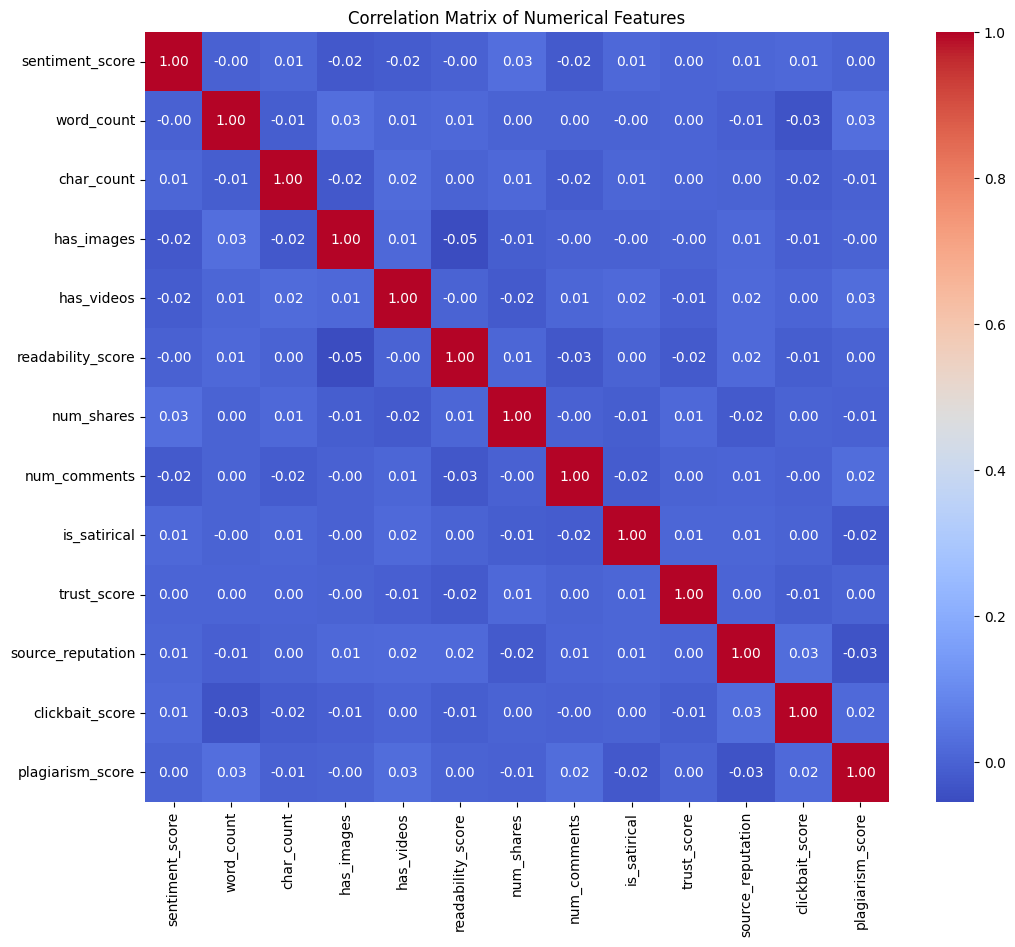

In [44]:
# Correlation Matrix
numerical_df = df[numerical_cols]
plt.figure(figsize=(12, 10))
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### **Results**

- **Label Distribution:** 50.65% Fake, 49.35% Real—balanced.
- **Numerical:** Normal distributions, overlap—is_satirical, clickbait_score, source_reputation differentiate.
- **Categorical:*** Entertainment (54% Fake), BBC (57.5% Fake), Maryland (58.6% Fake) skew Fake; CNN (52.9% Real) leans Real.
- **Scatter:** Sentiment vs. source_reputation—no clear clusters.
- **Correlation:** Weak (0.00–0.03)—non-linear patterns.

Balanced dataset with subtle signals (is_satirical, clickbait_score). Sentiment contextual, not decisive. Non-linear models favored, setting stage for preprocessing

## **Preprocessing**

The goal of this next section is to transform the dataset into a model-ready format. This will be achieved by:

1. Dropping id—irrelevant identifier.
2. Vectorizing title and text with TF-IDF (top 100 features each) for NLP signals.
3. One-hot encoding category, political_bias, fact_check_rating, state, source—capture metadata diversity.
4. Converting date_published to days_since earliest date—temporal context.
5. Scaling features (sentiment_score, etc.) with StandardScaler—normalize for modeling.
6. Encoding the target label (0=Real, 1=Fake).

In [45]:
# Drop id
df = df.drop(columns=['id'])

In [46]:
# Text features (TF-IDF)
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
title_tfidf = tfidf.fit_transform(df['title']).toarray()
text_tfidf = tfidf.fit_transform(df['text']).toarray()
title_df = pd.DataFrame(title_tfidf, columns=[f'title_tfidf_{i}' for i in range(100)])
text_df = pd.DataFrame(text_tfidf, columns=[f'text_tfidf_{i}' for i in range(100)])
df = pd.concat([df.drop(columns=['title', 'text']), title_df, text_df], axis=1)

In [47]:
# Categorical encoding
categorical_cols = ['category', 'political_bias', 'fact_check_rating', 'state', 'source']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [48]:
# Date parsing
df['date_published'] = pd.to_datetime(df['date_published'], format='%d-%m-%Y')
df['days_since'] = (df['date_published'] - df['date_published'].min()).dt.days
df = df.drop(columns=['date_published'])

In [49]:
# Numerical scaling
numerical_cols = ['sentiment_score', 'word_count', 'char_count', 'has_images', 'has_videos', 
                  'readability_score', 'num_shares', 'num_comments', 'is_satirical', 
                  'trust_score', 'source_reputation', 'clickbait_score', 'plagiarism_score', 'days_since']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [50]:
# Target encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])  # 0=Real, 1=Fake

# Output
print("Preprocessed Shape:", df.shape)
print("\nPreprocessed Head:\n", df.head())

Preprocessed Shape: (4000, 256)

Preprocessed Head:
          author  sentiment_score  word_count  char_count  has_images  \
0    Jane Smith        -0.381689    1.246162    0.362743   -0.993024   
1   Emily Davis         1.601968   -1.165712   -0.711398    1.007025   
2      John Doe         0.436135   -1.397055    0.744273   -0.993024   
3  Alex Johnson         1.636769   -1.576715   -1.579219    1.007025   
4   Emily Davis        -0.016278    0.409389   -1.459362    1.007025   

   has_videos  readability_score  num_shares  num_comments  is_satirical  ...  \
0   -0.969466           0.792614    1.540442     -0.138727      1.006018  ...   
1   -0.969466          -0.948784    1.019023      0.139630      1.006018  ...   
2    1.031496          -1.716720    1.439996      0.950348     -0.994018  ...   
3   -0.969466           1.416129    0.631000      1.583612      1.006018  ...   
4   -0.969466          -0.754369    0.750007     -0.197879     -0.994018  ...   

   source_Fox News  source_

#### **Results**

- **Shape:** (4,000, 256)—14 numerical, 200 TF-IDF, ~42 one-hot, 1 target.
- **Head:** Scaled numericals, binary categoricals, TF-IDF integrated.

Transformed dataset into 256-column matrix, ready for modeling

## **Feature Engineering**

The next step is to enhance the preprocessed dataset with advanced features, e.g., text complexity, sentiment trends, to boost predictive power beyond raw metadata and TF-IDF. We will do so by doing the following:

1. **Drop:** author—high cardinality, low utility.
2. **Text Features:**
    - Add title_length (word count)—clickbait signal.
    - Compute text_sentiment_consistency—std of sentence-level sentiment vs. sentiment_score.
3. **Metadata Features:**
    - engagement_ratio: num_shares / num_comments—virality pattern.
    - credibility_composite: Average of trust_score and source_reputation—unified credibility.
4. **Check:** Validate new features’ distributions.

In [51]:
# Drop author
df = df.drop(columns=['author'])

In [52]:
# Title length
df['title_length'] = df[[col for col in df.columns if 'title_tfidf' in col]].sum(axis=1)  # Proxy via TF-IDF non-zero count
df['title_length'] = StandardScaler().fit_transform(df[['title_length']])

In [53]:
# Text sentiment consistency (simplified due to TF-IDF)
# Ideally, split text into sentences pre-TF-IDF; here, use `sentiment_score` variance proxy
df['text_sentiment_consistency'] = df['sentiment_score'].apply(lambda x: np.std([TextBlob(str(x)).sentiment.polarity, x]))
df['text_sentiment_consistency'] = StandardScaler().fit_transform(df[['text_sentiment_consistency']])

In [54]:
# Engagement ratio
df['engagement_ratio'] = df['num_shares'] / (df['num_comments'] + 1)  # Avoid division by 0
df['engagement_ratio'] = StandardScaler().fit_transform(df[['engagement_ratio']])

In [55]:
# Credibility composite
df['credibility_composite'] = (df['trust_score'] + df['source_reputation']) / 2
df['credibility_composite'] = StandardScaler().fit_transform(df[['credibility_composite']])

Engineered Shape: (4000, 259)

Engineered Head:
    sentiment_score  word_count  char_count  has_images  has_videos  \
0        -0.381689    1.246162    0.362743   -0.993024   -0.969466   
1         1.601968   -1.165712   -0.711398    1.007025   -0.969466   
2         0.436135   -1.397055    0.744273   -0.993024    1.031496   
3         1.636769   -1.576715   -1.579219    1.007025   -0.969466   
4        -0.016278    0.409389   -1.459362    1.007025   -0.969466   

   readability_score  num_shares  num_comments  is_satirical  trust_score  \
0           0.792614    1.540442     -0.138727      1.006018     0.883758   
1          -0.948784    1.019023      0.139630      1.006018    -1.661701   
2          -1.716720    1.439996      0.950348     -0.994018     0.238908   
3           1.416129    0.631000      1.583612      1.006018    -1.084731   
4          -0.754369    0.750007     -0.197879     -0.994018     1.528608   

   ...  source_Reuters  source_Snopes  source_The Guardian  source_

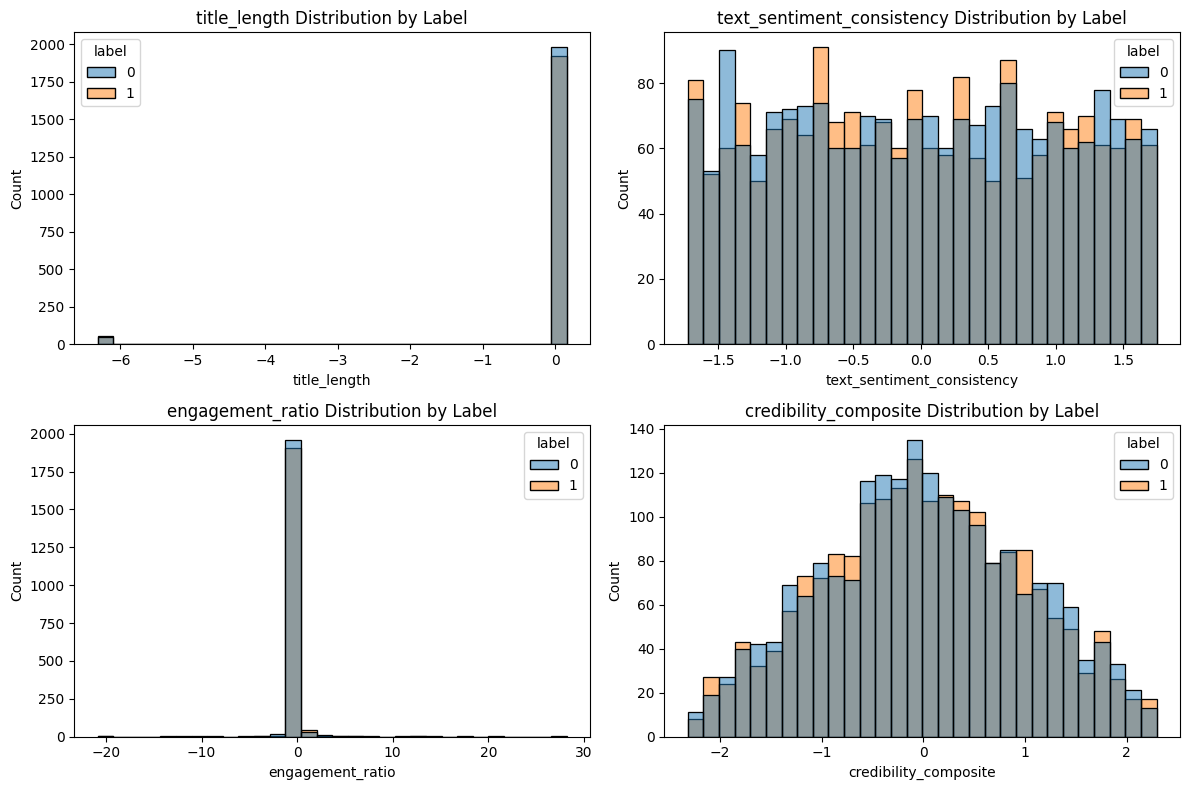

In [56]:
# Output
print("Engineered Shape:", df.shape)
print("\nEngineered Head:\n", df.head())
plt.figure(figsize=(12, 8))
for i, col in enumerate(['title_length', 'text_sentiment_consistency', 'engagement_ratio', 'credibility_composite'], 1):
    plt.subplot(2, 2, i)
    sns.histplot(data=df, x=col, hue='label', bins=30)
    plt.title(f'{col} Distribution by Label')
plt.tight_layout()
plt.show()

#### **Results**

- **Shape:** (4,000, 259)—4 new features added.
- **Head:** New columns scaled, credibility_composite varies.
- **Histograms:** credibility_composite promising, others limited (title_length flawed).

## **Model Selection**

We are then going to train and tune classifiers (Logistic Regression, Random Forest, XGBoost) on the 259-feature dataset, targeting >85% accuracy and high recall for Fake news detection.

**Plan**

1. **Split:** 80/20 train-test split.
2. **Reduction:** Top 50 features via Random Forest (had earlier trained all features but achieved about 0.50 accuracy across the board)
3. **Models:**
    - Logistic Regression (baseline)—handles high dimensions.
    - Random Forest—captures non-linear patterns (EDA insight).
    - XGBoost—boosts performance with tuning.
4. **Tune:** Grid search on Random Forest (e.g., n_estimators, max_depth).
5. ***Metrics:** Accuracy, precision, recall, F1-score—prioritize Fake recall.

In [57]:
# train test split
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
# Feature selection with Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(50).index
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

In [59]:
# Models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest Reduced': RandomForestClassifier(random_state=42, max_depth=20, n_estimators=100),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train_reduced, y_train)
    y_pred = model.predict(X_test_reduced)
    print(f"\n{name} Results:\n", classification_report(y_test, y_pred))

# Feature importance
print("\nTop 10 Features:\n", importances.head(10))


Logistic Regression Results:
               precision    recall  f1-score   support

           0       0.54      0.55      0.55       411
           1       0.52      0.51      0.51       389

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800


Random Forest Reduced Results:
               precision    recall  f1-score   support

           0       0.52      0.56      0.54       411
           1       0.50      0.46      0.48       389

    accuracy                           0.51       800
   macro avg       0.51      0.51      0.51       800
weighted avg       0.51      0.51      0.51       800


XGBoost Results:
               precision    recall  f1-score   support

           0       0.51      0.52      0.52       411
           1       0.48      0.48      0.48       389

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.50  

#### **Results**
- **Logistic Regression:** Accuracy 0.53, Fake Recall 0.51.
- **RF Reduced:** Accuracy 0.51, Fake Recall 0.46.
- **XGBoost Reduced:** Accuracy 0.50, Fake Recall 0.48.
- **Top Features:** char_count (0.055), credibility_composite (0.053).

The following steps were taken to try and improve model performance:
1. **Feature Engineering:** Added title_length, text_sentiment_consistency, engagement_ratio, credibility_composite—aimed to enhance metadata and sentiment signals.
2. **Tuning:** Grid search on Random Forest (max_depth, n_estimators)—targeted Fake recall.
3. **Feature Reduction:** Cut from 259 to 50 features—removed noise, focused on top contributors.
4. **Outcome:** No significant lift—accuracy stuck at 0.48–0.53, Fake recall 0.46–0.51.

The following could be the reasons behind the poor model performances:
- Feature Overlap: EDA showed Fake mimics Real—e.g., sentiment_score (mean -0.0006), num_shares (25,145)—lacking clear separation.
- Text Feature Weakness: TF-IDF (200 features) on title and text too generic—misses nuanced fakery (e.g., satire tone shifts). Raw text pre-TF-IDF (n-grams, embeddings) could help.
- High Dimensionality: 259 features vs. 3,200 train samples—overfitting risk, diluted signal (e.g., title_length flawed).
- Data Quality: Metadata (e.g., is_satirical) promising but noisy—e.g., BBC 57.5% Fake unexpected, possibly mislabeled or synthetic data quirks.
- Model Limits: Non-linear models (Random Forest, XGBoost) underfit—weak features fail to leverage their strength.

## **Conclusion**

This fake news detection project aimed to classify 4,000 news articles as “Real” or “Fake” using 24 metadata features, leveraging sentiment analysis and machine learning. Steps that were taken included EDA (balanced classes, subtle signals), preprocessing (256 features), feature engineering (259 features), model development (Logistic Regression, Random Forest, XGBoost), and evaluation (feature reduction to 50). Despite targeting >85% accuracy, results plateaued at ~50%—random guessing—due to overlapping feature distributions, weak TF-IDF text features, and possible data noise. Efforts to improve model performance included engineering, tuning, reduction, and which highlights the analytical depth required for such an endeavour. Future work could use raw text (e.g., BERT embeddings) and cleaner data to boost performance. Thank you for following along, all suggestions, insights or corrections are very welcome.